In [49]:
import pandas as pd
import numpy as np

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
joint_seed_experiment_results = pd.read_csv('evaluate/seed-experiment-results/joint/aggregate/aggregate-seed-experiment-results-041120.csv')

In [52]:
joint_seed_experiment_results['is_joint'] = 'joint'

In [53]:
nonjoint_seed_experiment_results = pd.read_csv('evaluate/seed-experiment-results/nonjoint/aggregate/aggregate-seed-experiment-results-060520.csv')

In [54]:
nonjoint_seed_experiment_results['is_joint'] = 'nonjoint'

In [55]:
joint_seed_experiment_results.shape

(120, 5)

In [56]:
nonjoint_seed_experiment_results.shape

(120, 5)

In [57]:
seed_experiment_results = pd.concat([joint_seed_experiment_results, nonjoint_seed_experiment_results], ignore_index=True)

### Exploratory analysis

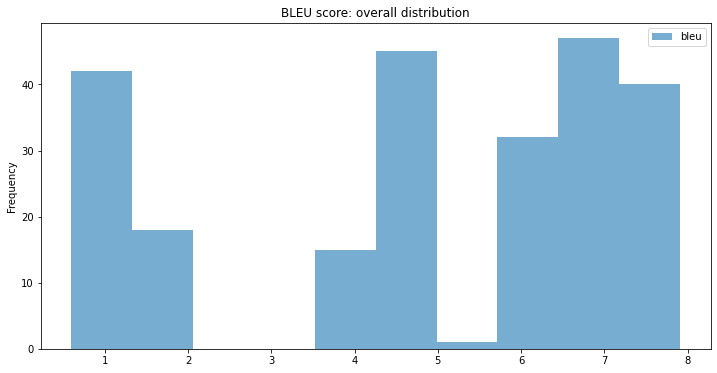

In [58]:
t = 'BLEU score: overall distribution'
seed_experiment_results\
    .bleu.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               legend=True)

It's clearly a multimodal distribution. It's also interesting to ask what the effect of joint vs. nonjoint BPE is: 

is_joint
joint       AxesSubplot(0.125,0.125;0.775x0.755)
nonjoint    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

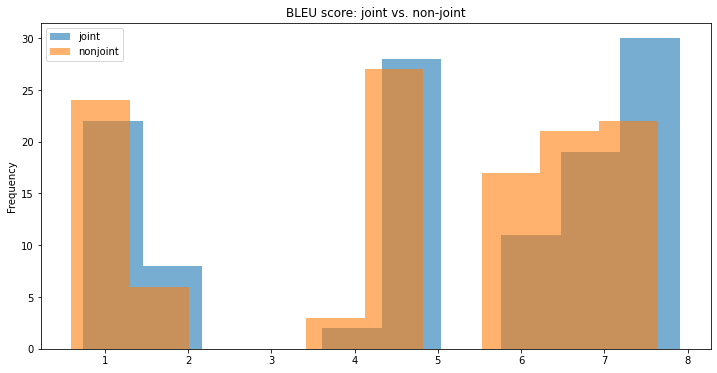

In [59]:
t = 'BLEU score: joint vs. non-joint'
seed_experiment_results\
    .groupby('is_joint')\
    .bleu.plot(kind='hist', title=t,
               alpha=0.6, figsize=(12, 6),
               legend=True)

This seems like a rather clear effect: non-joint seems to be decreasing the BLEU score no matter what.

What about the relationship between BPE level and BLEU?

bpe
2500    AxesSubplot(0.125,0.125;0.775x0.755)
5000    AxesSubplot(0.125,0.125;0.775x0.755)
7500    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

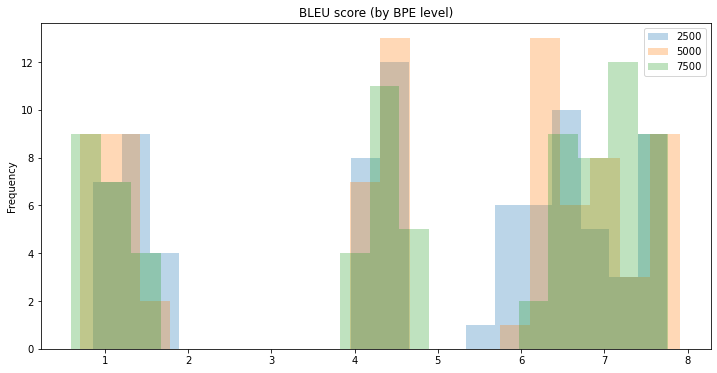

In [60]:
t = 'BLEU score (by BPE level)'
seed_experiment_results\
    .groupby('bpe')\
    .bleu.plot(kind='hist', title=t, bins=20,
               alpha=0.3, figsize=(12, 6),
               legend=True)

This effect seems far more "muddled"! We can clearly see that each cluster in our model contains observations from each BPE setting.

language_pair
en-ne    AxesSubplot(0.125,0.125;0.775x0.755)
en-si    AxesSubplot(0.125,0.125;0.775x0.755)
ne-en    AxesSubplot(0.125,0.125;0.775x0.755)
si-en    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bleu, dtype: object

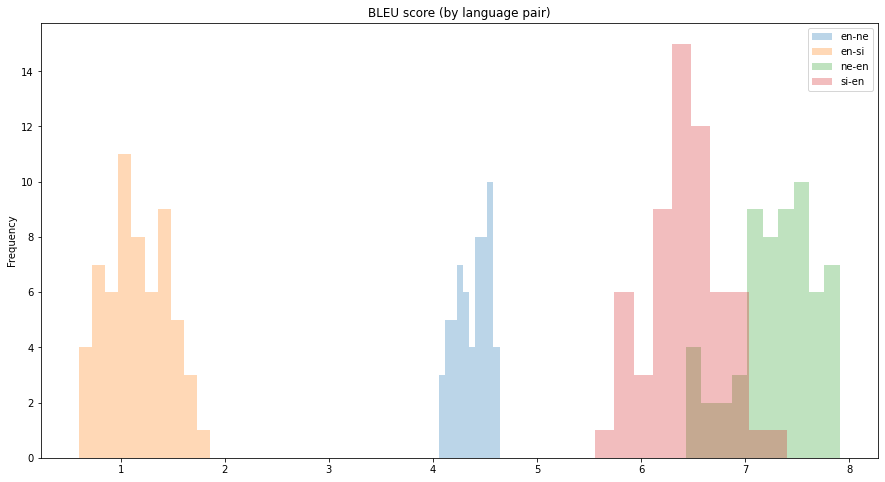

In [61]:
t = 'BLEU score (by language pair)'
seed_experiment_results\
    .groupby('language_pair')\
    .bleu.plot(kind='hist', title=t,
               alpha=0.3, figsize=(15, 8),
               legend=True)

This lays out the clusters very nicely! There seem to be about 4 clusters in our data, one for each language pair. We can also see the nice breakdown into experimental settings where English is the target language, and where SI/NE is the target language.

## Bayesian model

Ultimately we want to be fitting a linear model:

$$
\text{BLEU}^l = \eta^l + \tau^l_{b} + \mu^l_j + \epsilon
$$

where $\eta$ is the "language pair effect", $\tau$ is the "bpe effect" and $\mu$ is the joint/nonjoint effect. We let all effects vary between language pairs and also give all parameters a common prior distribution:


$$
\theta \sim N(0,1)\text{ for all }\theta \in \{\eta, \tau, \mu, \epsilon\}
$$

Since we repeated the experiments with seeds, we'll get an idea of "sampling variation" here as well.

In [62]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [63]:
bpe_enc = LabelEncoder()
lang_pair_enc = LabelEncoder()

In [64]:
lang_pair_data = lang_pair_enc.fit_transform(seed_experiment_results.language_pair)
bpe_data = bpe_enc.fit_transform(seed_experiment_results.bpe)
bleu_data = seed_experiment_results.bleu

In [65]:
n_lang_pairs = 4
n_bpes = 3

#### A dumb model

First fit a global model that is language-agnostic in terms of the baseline BLEU. This corresponds to

$$
\text{BLEU}^l = \eta + \tau_b + \epsilon
$$

That is, we assume a language-independent baseline effect, as well as a language-independent "treatment effect" of changing the BPE.

In [66]:
def fit_dumb_model():
    with pm.Model() as linear_model:

        eta = pm.Normal('eta', mu=0, sigma=1)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_bpes)
        b = eta + tau[bpe_data]
        noise = pm.HalfCauchy('noise', 5)

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=noise,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive()
        posterior = pm.sample()
        posterior_pred = pm.sample_posterior_predictive(posterior)
        return prior, posterior, posterior_pred

In [67]:
prior, posterior, posterior_pred = fit_dumb_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]
100%|██████████| 2000/2000 [00:02<00:00, 848.09it/s]


In [68]:
def posterior_predictive_check():
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism['bleu_fake'] = posterior_pred['bleu_observed'][rand_ix]
    criticism['bleu_obs'] = bleu_data
    criticism.plot(kind='hist', alpha=0.7, title='Posterior predictive check: BLEU', figsize=(12,6), bins=30)

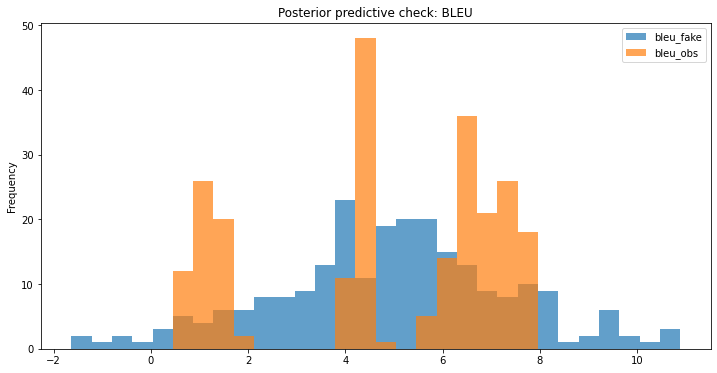

In [69]:
# model criticism
posterior_predictive_check()

Clearly fitting a single model is not the right thing to do here. We can also fit separate models:

#### Language pair -level model

This is the original model described above without the $\mu_j$ terms:

$$
\text{BLEU}^l = \eta^l + \tau^l_b + \epsilon
$$

In contrast to the first dumb model, we now allow the baseline and treatment effects to vary according to language.

In [70]:
combined_lp_bpe = list(zip(seed_experiment_results.language_pair, seed_experiment_results.bpe))

In [71]:
combo_enc = LabelEncoder()

In [72]:
combined_lp_bpe = [f"{t[0]}-{t[1]}" for t in combined_lp_bpe]

In [73]:
combined_lp_bpe_data = combo_enc.fit_transform(combined_lp_bpe)

In [74]:
n_combined = 12

In [75]:
def fit_shared_model(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_combined)
        b = eta[lang_pair_data] + tau[combined_lp_bpe_data]
        noise = pm.HalfCauchy('noise', 5)

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=noise,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [76]:
m2, prior, posterior, posterior_pred = fit_shared_model(n=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [02:00<00:00, 347.70draws/s]
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:10<00:00, 914.68it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5af2e3950>,
      dtype=object)

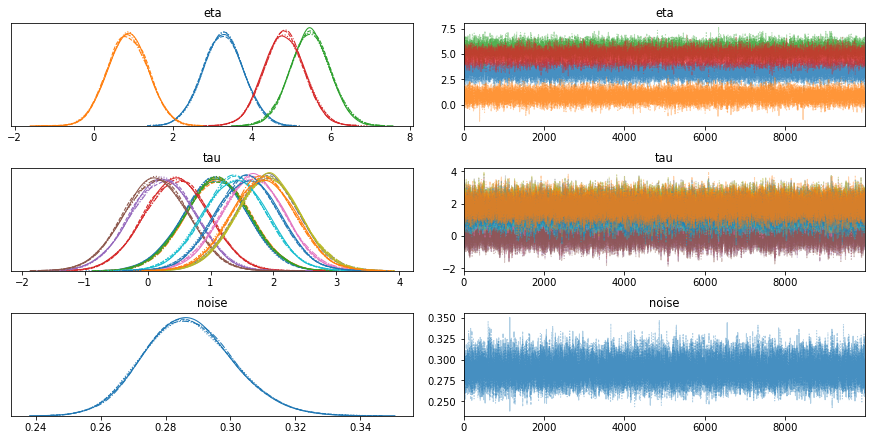

In [77]:
pm.traceplot(posterior)

In [87]:
# pm.forestplot(posterior)

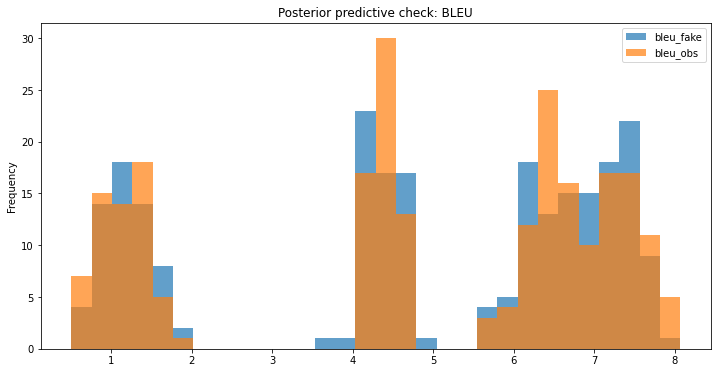

In [79]:
posterior_predictive_check()

A much, much better fit!

#### Accounting for unequal variances

Let's expand the model from above and allow for an unequal variance term. That is, now:

$$
\text{BLEU}^l = \eta^l + \tau^l_b + \epsilon^l
$$

where $\epsilon^l \sim \mathcal{N}(0, \sigma^2_l)$

In [80]:
def fit_unequal_variance_shared_model(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_combined)
        b = eta[lang_pair_data] + tau[combined_lp_bpe_data]
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [81]:
_, prior, posterior, posterior_pred = fit_unequal_variance_shared_model(n=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [03:42<00:00, 188.57draws/s]
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:11<00:00, 858.57it/s]


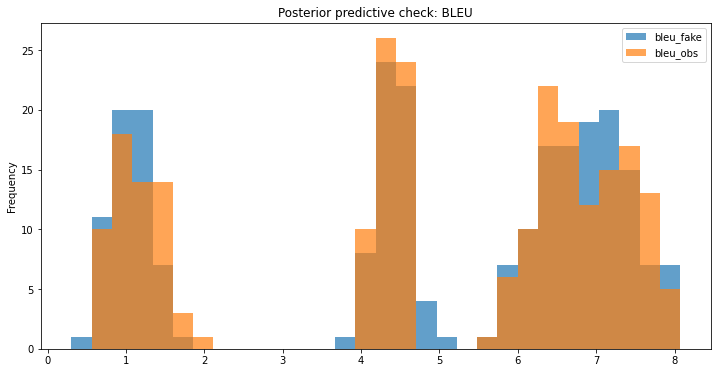

In [82]:
posterior_predictive_check()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5ad85e850>],
      dtype=object)

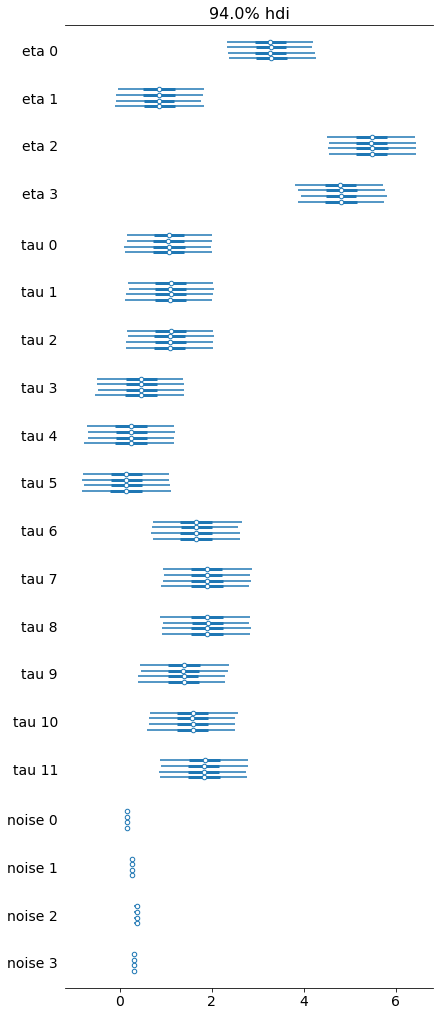

In [85]:
pm.forestplot(posterior)

In [89]:
pm.traceplot?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5acff7450>,
      dtype=object)

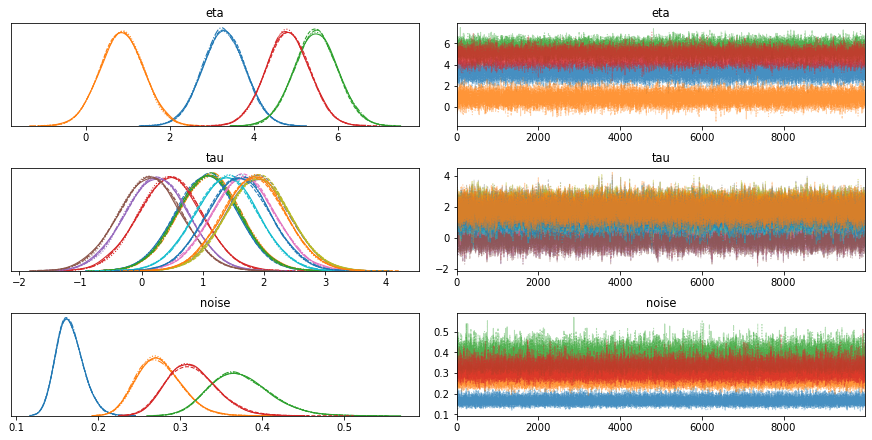

In [92]:
pm.traceplot(posterior)

It's interesting to note that the variances, though unequal in their distribution, vary relatively little compared to the other terms. This is actually exactly what we want: the residual variance not explained by our experimental condition tweaks **should** be small!

Now let's fit the model with a joint/non-joint effect:

#### Model with joint/non-joint effect

In [105]:
joint_nonjoint_enc = LabelEncoder()

In [110]:
mu_vals = ["mu-{}-{}".format(t[0], t[1]) for t in zip(seed_experiment_results.language_pair, seed_experiment_results.is_joint)]

In [111]:
joint_nonjoint_data = joint_nonjoint_enc.fit_transform(mu_vals)

In [112]:
n_joint_nonjoint = len(set(joint_nonjoint_data))

In [113]:
def fit_joint_nonjoint_model(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_combined)
        mu = pm.Normal('mu', mu=0, sigma=1, shape=n_joint_nonjoint)
        
        b = eta[lang_pair_data] + tau[combined_lp_bpe_data] + mu[joint_nonjoint_data]
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [114]:
_, prior, posterior, posterior_pred = fit_joint_nonjoint_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, mu, tau, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:33<00:00, 106.43draws/s]
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 871.35it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a7cf38d0>,
      dtype=object)

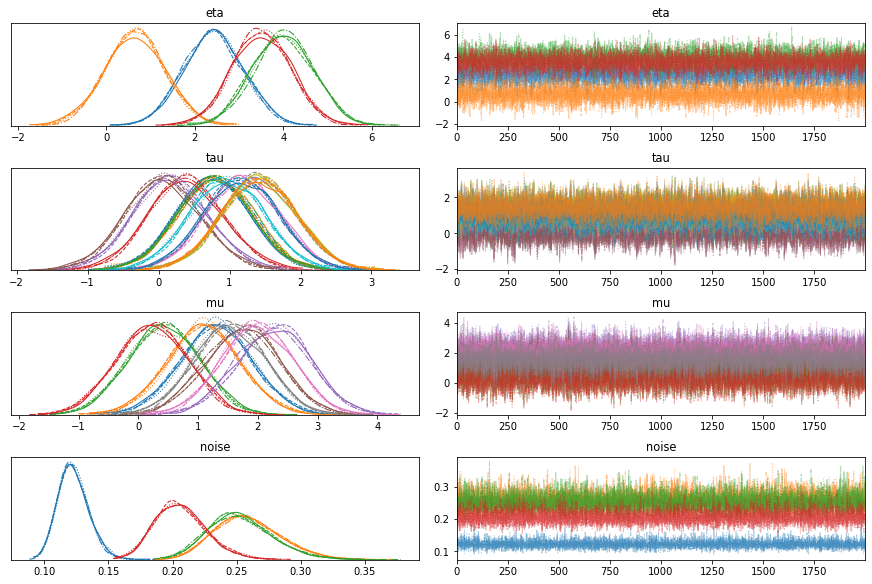

In [115]:
pm.traceplot(posterior)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a723e2d0>],
      dtype=object)

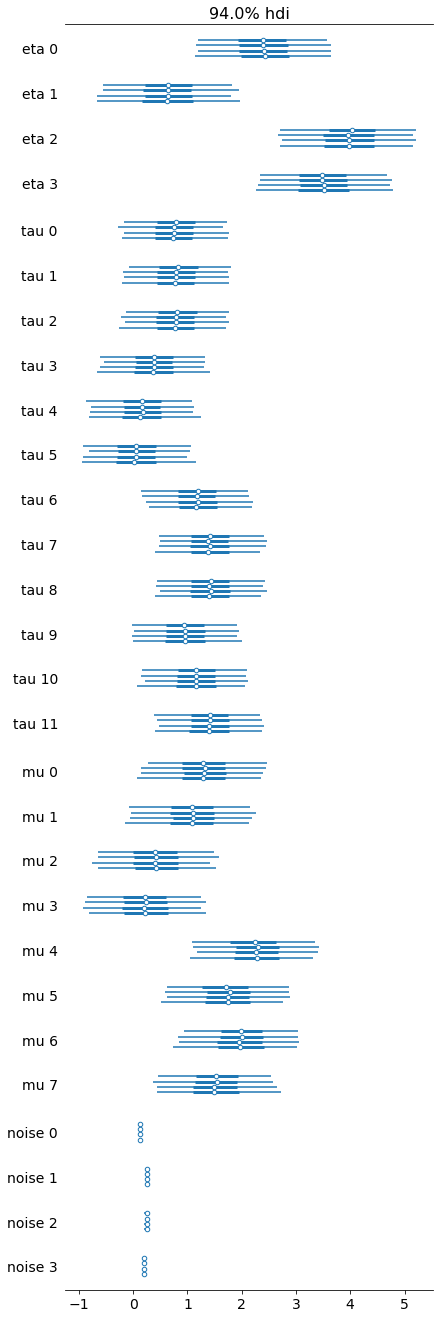

In [116]:
pm.forestplot(posterior)

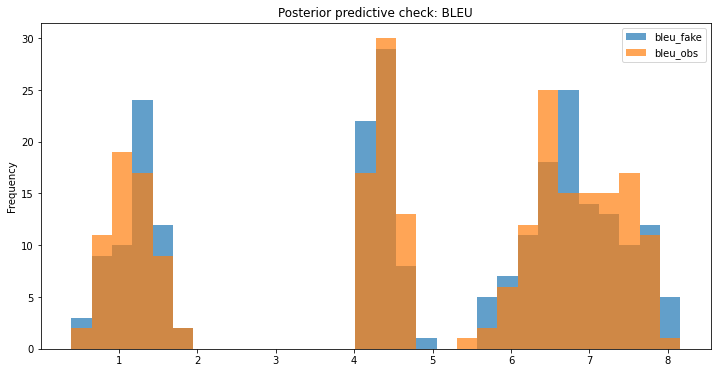

In [122]:
posterior_predictive_check()

The posterior predictive distribution replicates the data remarkably well. 

However, there seem to be problems identifying the $\mu^l_j$ and $\tau^l_b$ parameters.

Let's fit a model where we collapse all $\tau^l _b$ to $\tau_b$ and all $\mu^l_j$ to $\mu_j$:

#### Model with shared mu and tau

In [127]:
joint_nonjoint_enc_shared = LabelEncoder()
tau_enc_shared = LabelEncoder()

In [126]:
shared_joint_nonjoint = joint_nonjoint_enc_shared.fit_transform(seed_experiment_results.is_joint)

In [128]:
shared_bpe = tau_enc_shared.fit_transform(seed_experiment_results.bpe)

In [129]:
n_shared_joint_nonjoint = len(set(shared_joint_nonjoint))
n_shared_bpe = len(set(shared_bpe))

In [140]:
def fit_joint_nonjoint_model_shared_mu_tau(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_shared_bpe)
        mu = pm.Normal('mu', mu=0, sigma=1, shape=n_shared_joint_nonjoint)
        
        delta_mu = pm.Deterministic('mu_joint - mu_nonjoint', mu[1] - mu[0])
        
        b = eta[lang_pair_data] + tau[shared_bpe] + mu[shared_joint_nonjoint]
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [141]:
_, prior, posterior, posterior_pred = fit_joint_nonjoint_model_shared_mu_tau()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, mu, tau, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:56<00:00, 177.12draws/s]
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 872.90it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a7d2cd50>,
      dtype=object)

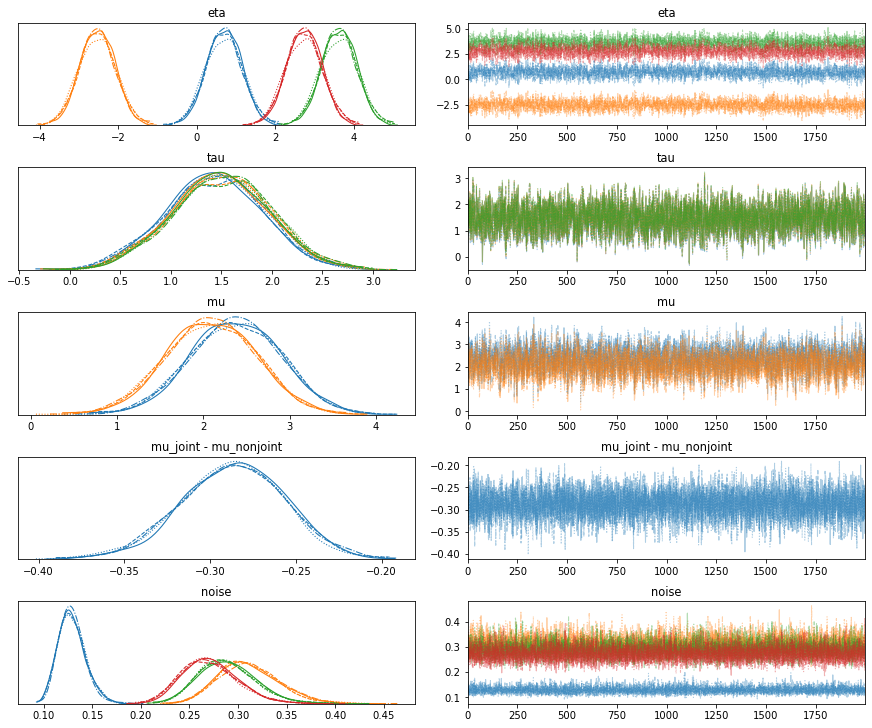

In [142]:
pm.traceplot(posterior)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a5af6a10>],
      dtype=object)

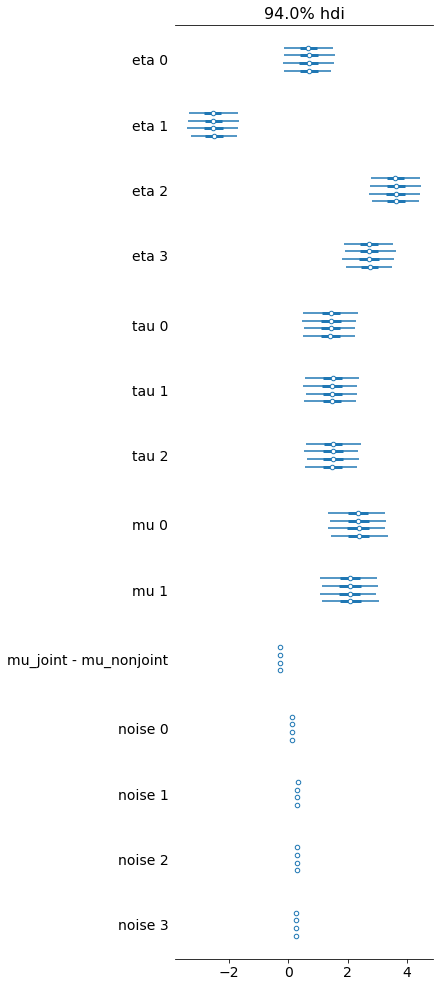

In [143]:
pm.forestplot(posterior)

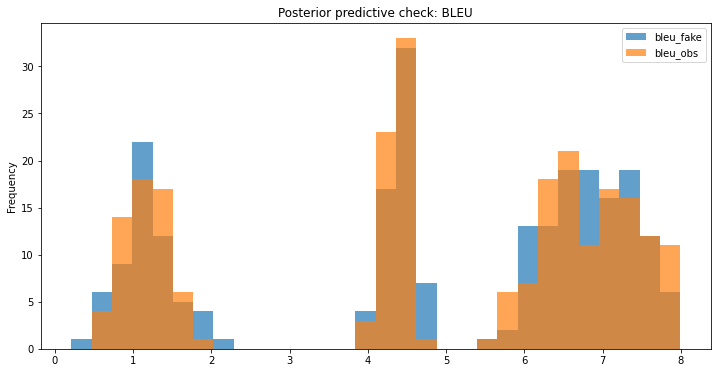

In [134]:
posterior_predictive_check()

Yet another good fit. It's interesting to note how little effect BPE alone seems to have! The models where we used an interaction term of language pair and BPE had much more informative posterior inferences than this one.

This could be a signal that maybe the $\tau$ terms are irrelevant? As in, maybe the $\eta$ terms can just absorb the effect? 

Let's fit a model without the $\tau$ terms and see: 

#### Model without tau

In [144]:
def fit_model_without_tau(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        #tau = pm.Normal('tau', mu=0, sigma=1, shape=n_shared_bpe)
        mu = pm.Normal('mu', mu=0, sigma=1, shape=n_shared_joint_nonjoint)
        
        delta_mu = pm.Deterministic('mu_joint - mu_nonjoint', mu[1] - mu[0])
        
        b = eta[lang_pair_data] + mu[shared_joint_nonjoint] # tau[shared_bpe] + 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [145]:
_, prior, posterior, posterior_pred = fit_model_without_tau()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, mu, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:37<00:00, 265.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 913.62it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a4a42f90>,
      dtype=object)

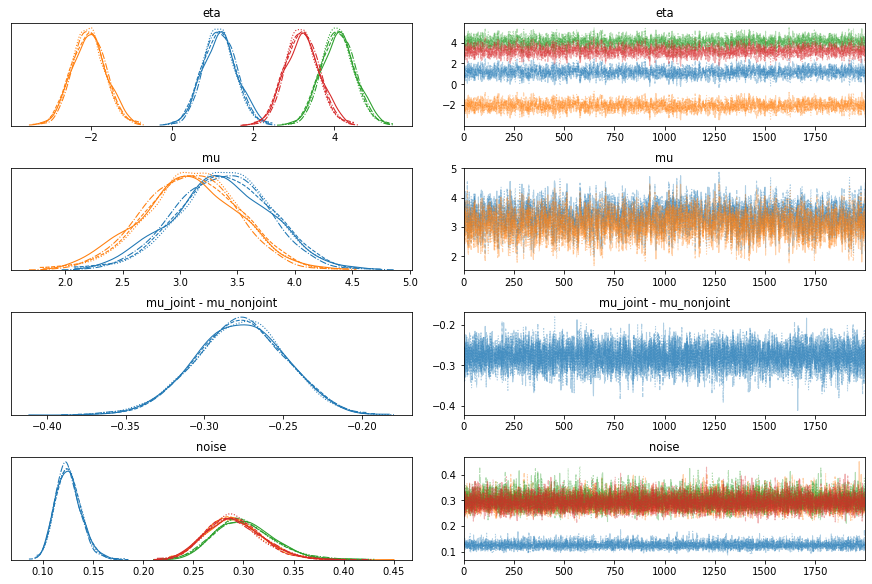

In [146]:
pm.traceplot(posterior)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5af634450>],
      dtype=object)

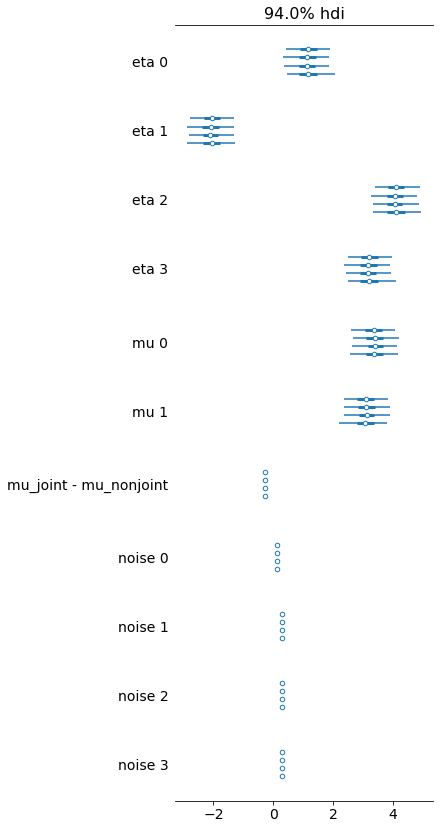

In [147]:
pm.forestplot(posterior)

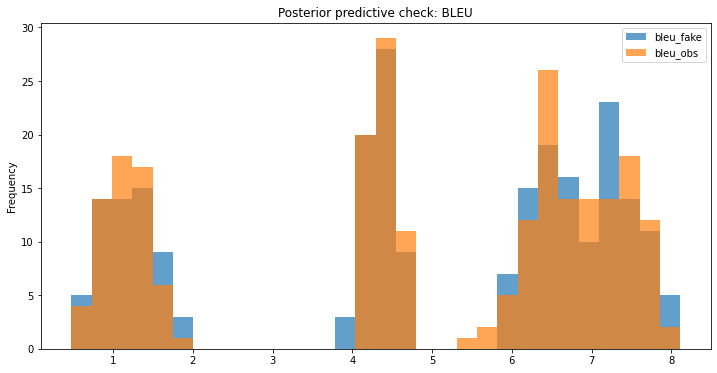

In [153]:
posterior_predictive_check()

The $\eta$-terms indeed seem to be able to capture this very well!

In [155]:
def fit_model_without_tau_multiplicative_mu(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        mu = pm.Normal('mu', mu=0, sigma=1)
        
        b = eta[lang_pair_data] + shared_joint_nonjoint*mu 
        
        noise = pm.HalfCauchy('noise', 5, shape=n_lang_pairs)
        eps = noise[lang_pair_data]

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=eps,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [156]:
_, prior, posterior, posterior_pred = fit_model_without_tau_multiplicative_mu()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, mu, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1960.53draws/s]
The acceptance probability does not match the target. It is 0.8835078127475364, but should be close to 0.8. Try to increase the number of tuning steps.
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 874.34it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a3569550>,
      dtype=object)

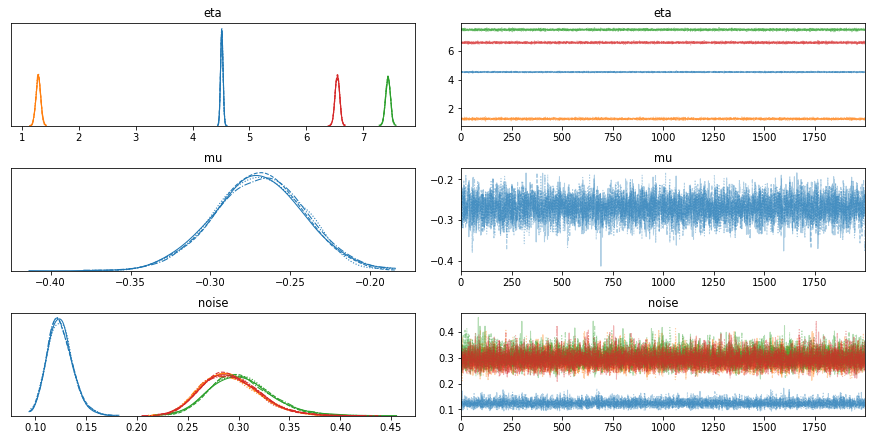

In [157]:
pm.traceplot(posterior)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5a3751890>],
      dtype=object)

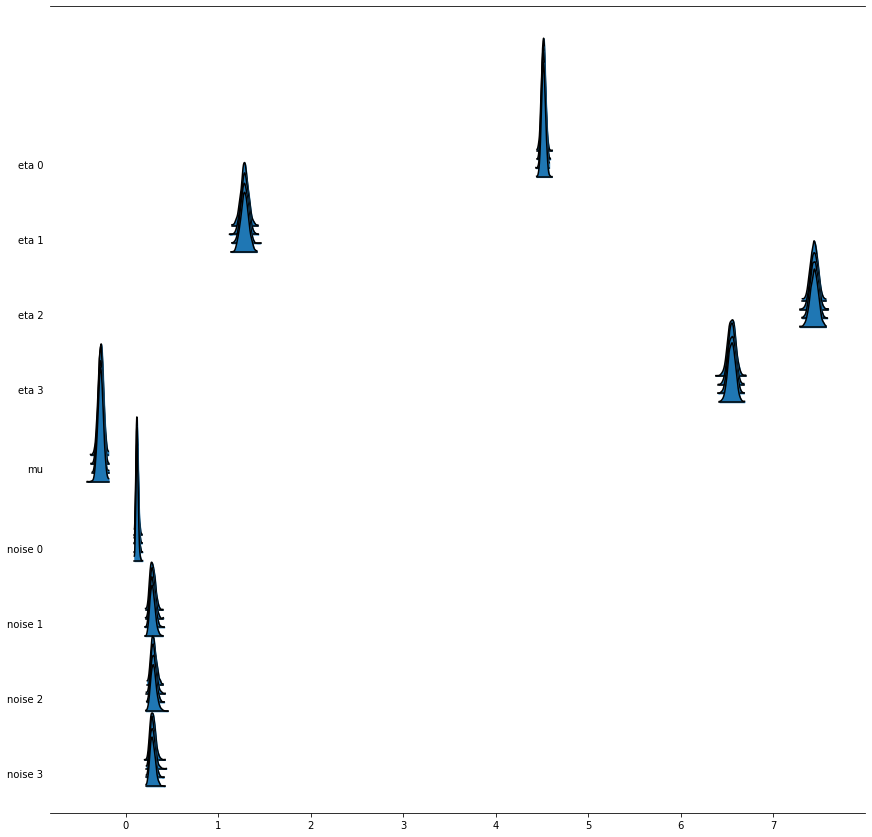

In [159]:
pm.forestplot(posterior, kind='ridgeplot')

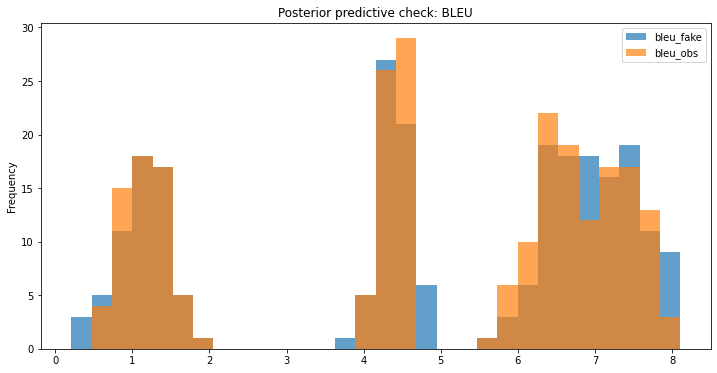

In [160]:
posterior_predictive_check()

## Old pre-modeling plots

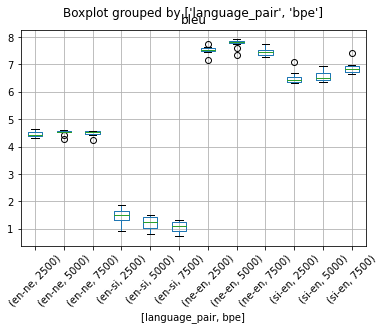

In [43]:
seed_experiment_results\
    .drop('seed', 1)\
    .set_index('bpe')\
    .boxplot(by=['language_pair','bpe'], rot=45)

In [44]:
import seaborn as sns

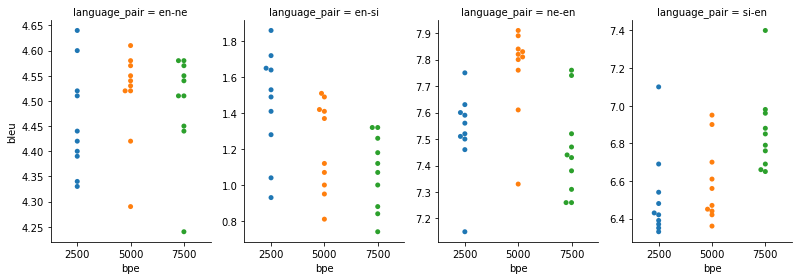

In [45]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="swarm",
            height=4, aspect=.7, sharex=False, sharey=False);

In [9]:
# sns.catplot(x="bpe", y="bleu", col="language_pair",
#             data=seed_experiment_results, kind="box",
#             height=4, aspect=.7, sharex=False, sharey=False);

In [10]:
# sns.catplot(x="bpe", y="bleu", col="language_pair",
#             data=seed_experiment_results, kind="strip",
#             height=4, aspect=.7, sharex=False, sharey=False)

In [7]:
# sns.catplot(x="bpe", y="bleu", col="language_pair",
#             data=seed_experiment_results, kind="strip",
#             height=4, aspect=.7, sharex=False, sharey=True)

In [8]:
# sns.lmplot(x="bpe", y="bleu", col="language_pair", data=seed_experiment_results,
#            col_wrap=2, ci=None, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 1})